In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]
PyTorch version 2.4.1
Torchvision version 0.19.1
Numpy version 1.26.4
Pandas version 2.2.2


In [3]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes
    


In [15]:

data_dir = 'D:/STUDY/MS/DATS 6450 Computer Vision/pyTorch/playing card dataset/train'
dataset = PlayingCardDataset(data_dir=data_dir)


len(dataset)
dataset[0]

image, label = dataset[0]

target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [4]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

## *Model Creation*

In [5]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children()))[:-1]

        enet_out_size = 1280

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):

        x = self.features(x)
        output = self.classifier(x)
        return output

In [7]:
model = SimpleCardClassifier(num_classes=53)
print(str(model)[:500])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [6]:
train_folder = 'D:/STUDY/MS/DATS 6450 Computer Vision/pyTorch/playing card dataset/train'
test_folder = 'D:/STUDY/MS/DATS 6450 Computer Vision/pyTorch/playing card dataset/test'
valid_folder = 'D:/STUDY/MS/DATS 6450 Computer Vision/pyTorch/playing card dataset/valid'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)
valid_dataset = PlayingCardDataset(valid_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [8]:
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc='Training loop'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
        
        val_loss = running_loss / len(valid_loader.dataset)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

    
    

Validation loop: 100%|██████████| 9/9 [00:00<00:00, 16.50it/s]


Epoch 1/5 - Train loss: 1.639367043033852, Validation loss: 0.4505749850902917


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 15.78it/s]


Epoch 2/5 - Train loss: 0.6074797600539008, Validation loss: 0.17914760180239409


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 15.97it/s]


Epoch 3/5 - Train loss: 0.3540672990889264, Validation loss: 0.19009763609688238


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 15.78it/s]


Epoch 4/5 - Train loss: 0.2360366602337373, Validation loss: 0.20229513774502952


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 16.38it/s]

Epoch 5/5 - Train loss: 0.20728721273408232, Validation loss: 0.17227638307607399


In [11]:
train_loss

0.20728721273408232

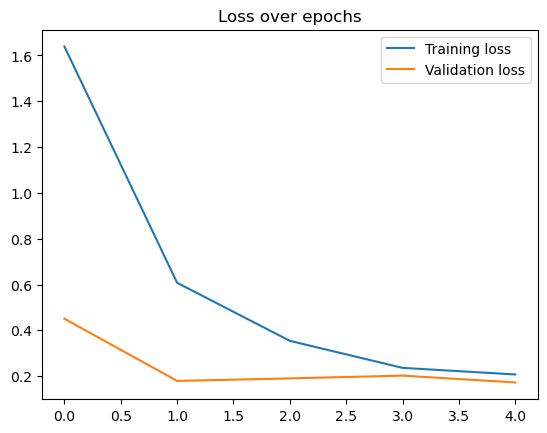

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Evaluate the results

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()




In [19]:
test_image = "D:/STUDY/MS/DATS 6450 Computer Vision/pyTorch/playing card dataset/test/nine of hearts/4.jpg"

original_image, image_tensor = preprocess_image(test_image, transform)
prob = predict(model, image_tensor, device)

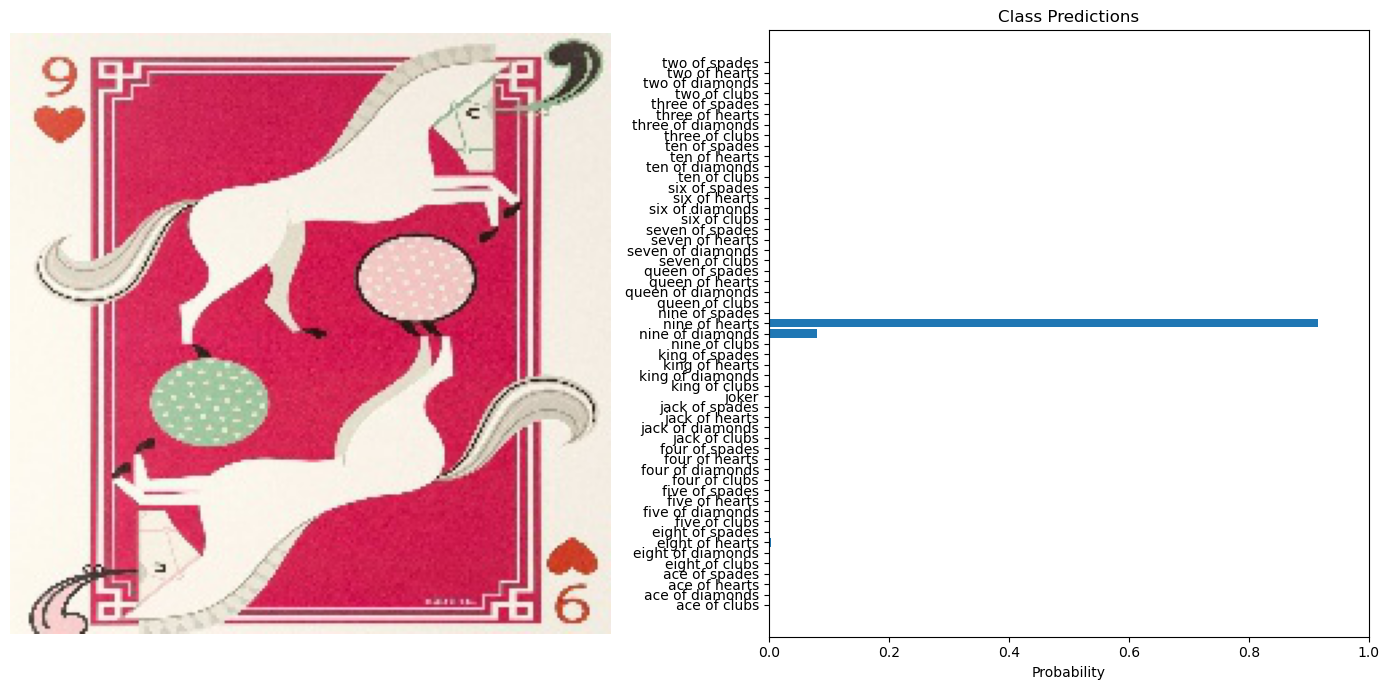

In [20]:
class_names = dataset.classes

visualize_predictions(original_image, prob, class_names)
# print(class_names)

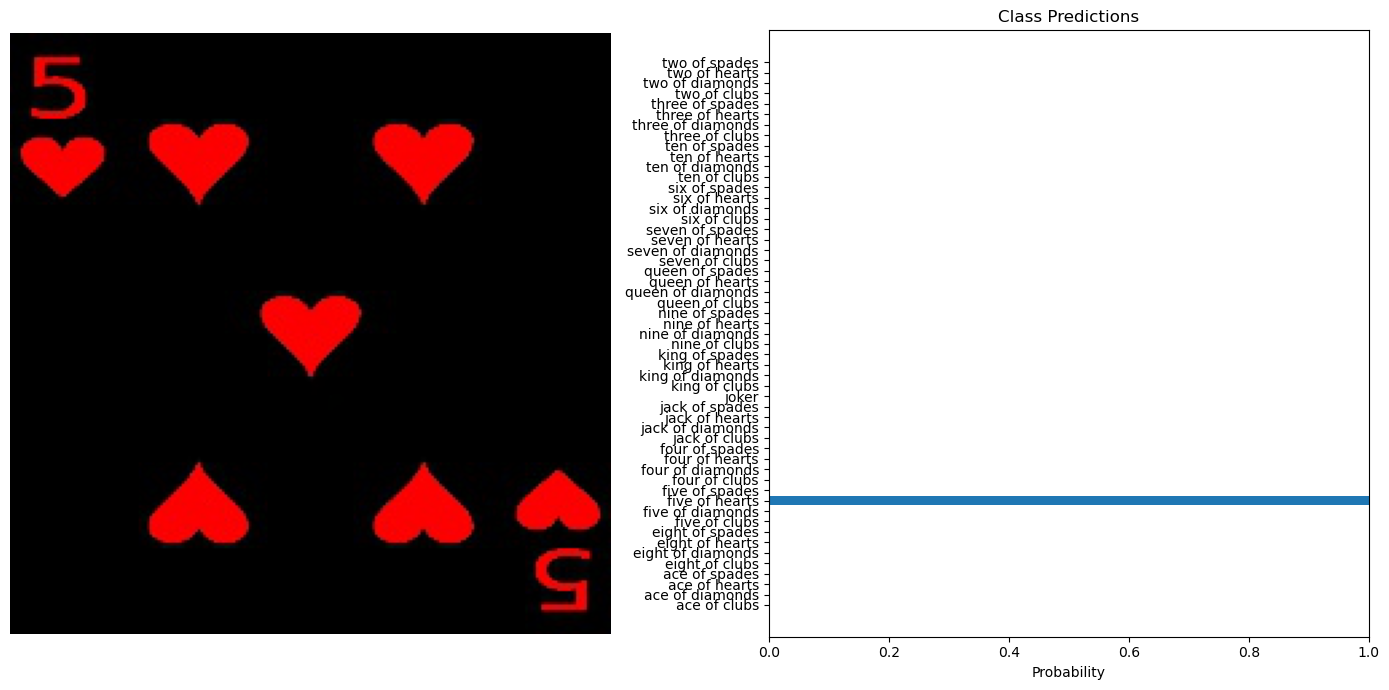

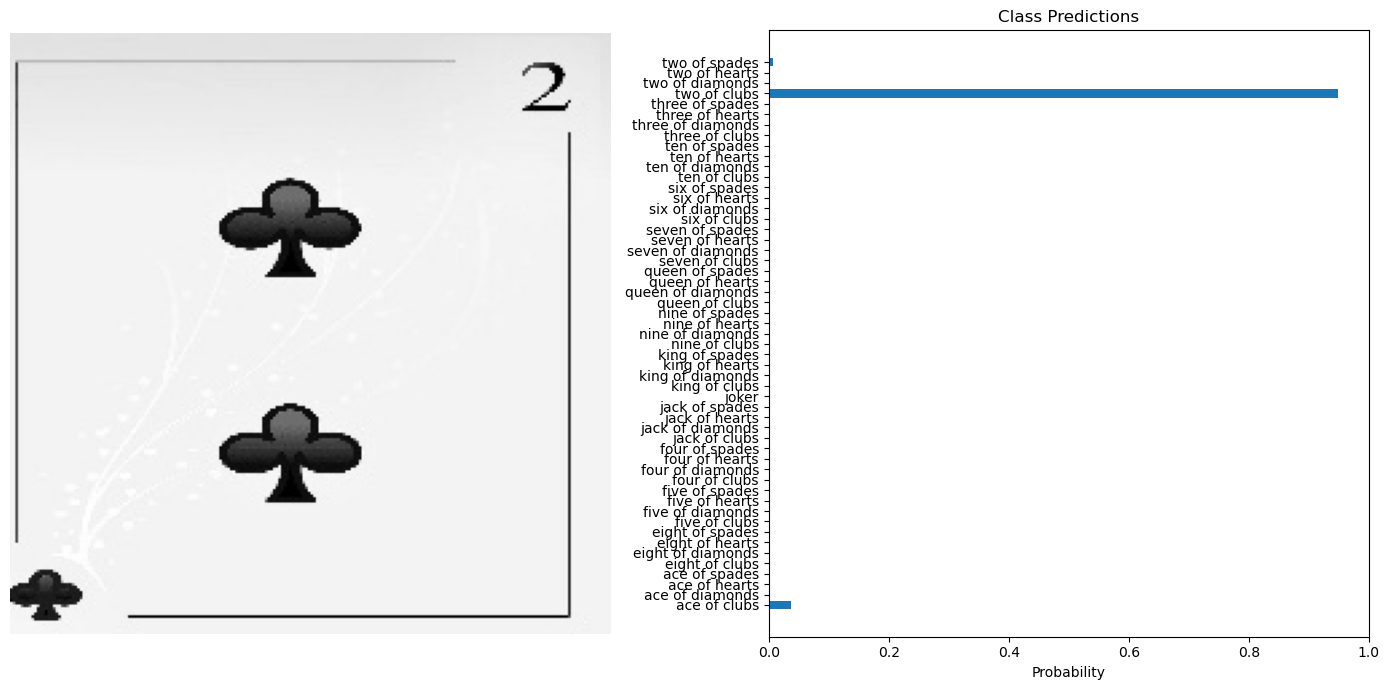

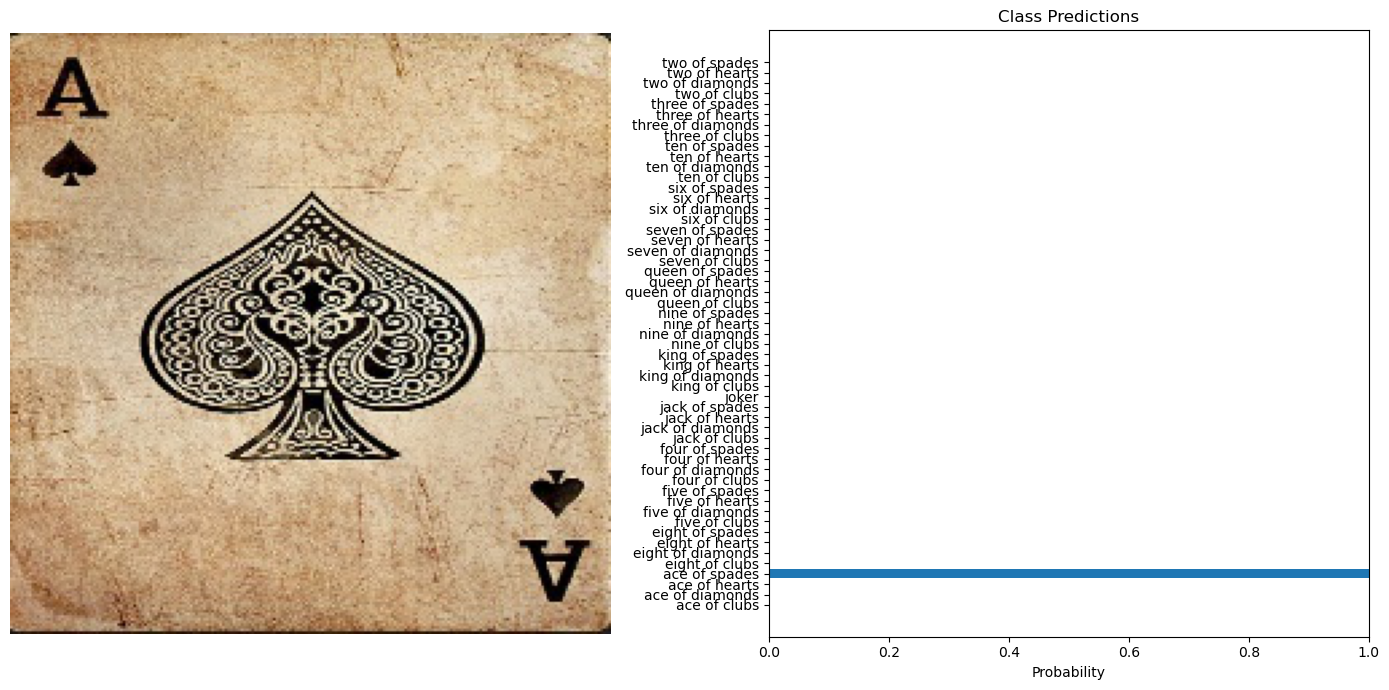

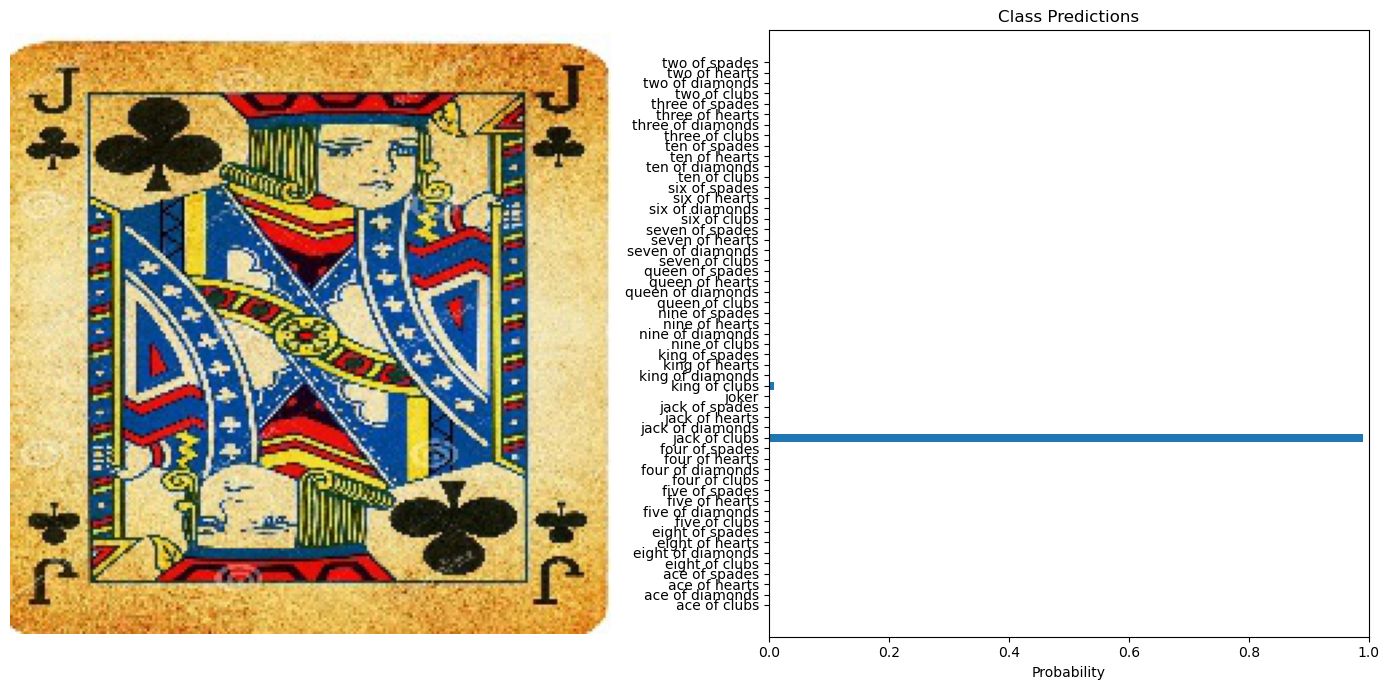

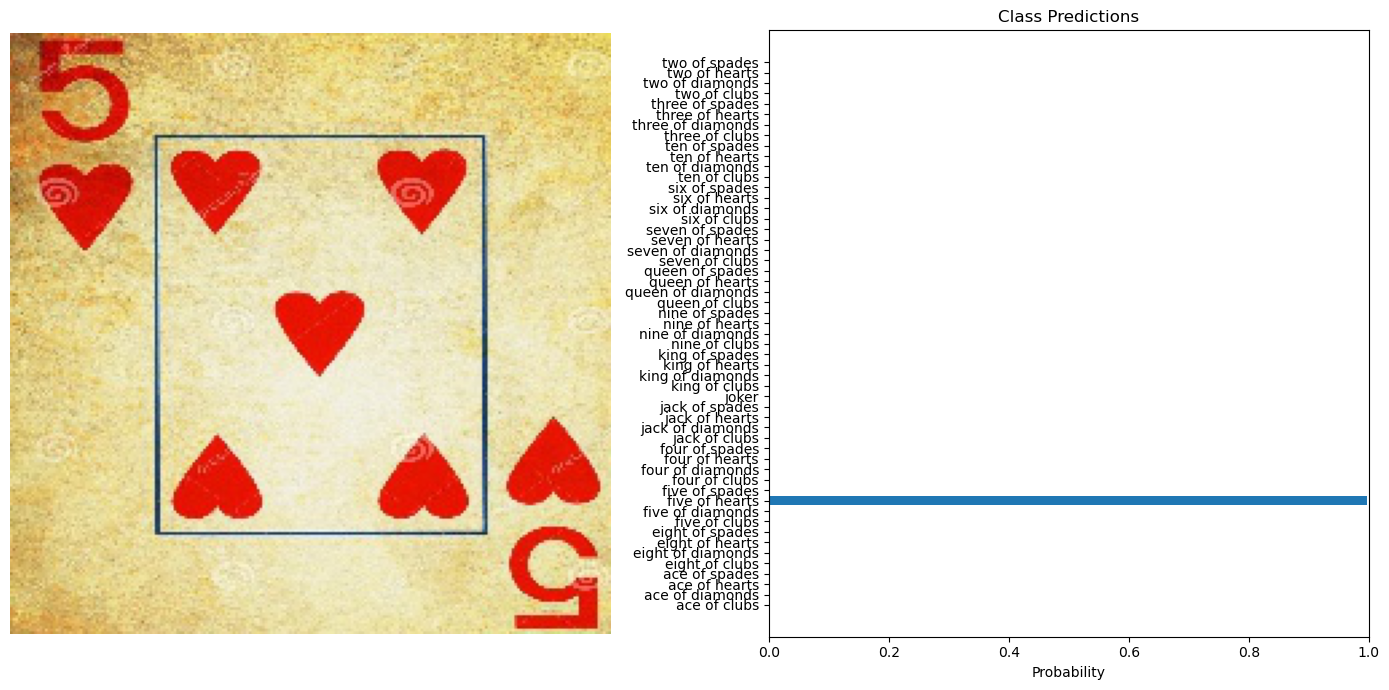

In [25]:
from glob import glob

test_images = glob("D:/STUDY/MS/DATS 6450 Computer Vision/pyTorch/playing card dataset/test/*/*")

examples = np.random.choice(test_images, 10)

for example in examples:
    original_image, image_tensor = preprocess_image(example, transform)
    prob = predict(model, image_tensor, device)
    visualize_predictions(original_image, prob, class_names)

## Accuracy on the Test Dataset

In [32]:
test_losses = []
test_correct = 0
test_total = 0

model.eval()
running_loss = 0.0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing Loop', disable=True):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)  # Corrected 'output' to 'outputs'
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)

        # calculating accuracy
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    test_accuracy = (test_correct / test_total) * 100
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.2360, Test Accuracy: 91.70%
